In [ ]:
!pip install transformers
# !pip install transformers==4.28.0

In [ ]:
#install hugging face evaluate 
!pip install evaluate

In [ ]:
#!pip uninstall -y transformers accelerate
#!pip install transformers accelerate

In [2]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import pipeline

from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap

import evaluate

from sklearn.metrics import confusion_matrix, classification_report  


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
     

In [5]:
# Data
# Dutch trainset/valset 

nl_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /train_dutch.csv") 
nl_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /val_dutch.csv") 

In [6]:
nl_trainset


,messages_dutch,label
0,"['Hey, hoe gaat het?', 'Hey.', 'Wat?', 'Niet v...",1
1,"['asl.', 'Ik ben een man van 18 jaar, op zoek ...",0
2,"['Hallo.', 'Hi owo', 'Ik moet poppen.', ':D', ...",0
3,"['Hallo.', ""Ik krijg dit: release\\myclass.o(....",0
4,"['Hallo.', 'Hey daar.', 'ASL?', 'U man?', 'im ...",0
...,...,...
5265,"['Hallo.', 'heb een tool nodig om unix/samba-a...",0
5266,"['Wat doe je liefje?', 'We zoeken dingen op.',...",1
5267,"['Haï', 'asl.', 'Hey :D', 'haha omg.. quicky.'...",0
5268,"['hiii asl?', 'Hallo.', 'm', 'Im 15 f.', 'Im 1...",0


In [7]:
#Dutch test set 
nl_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_dutch.csv')

In [ ]:
nl_testset

,id,isCybergrooming,authors,messages,messages_de,label
0,de15188e9fd515ed817a0b34546be902,True,"[{'id': 'b6fe182274453b707870b16e5d2ad562', 'i...",[{'author': 'b6fe182274453b707870b16e5d2ad562'...,"['achterin.', 'Oké baby.', 'Wat is er gebeurd,...",1
1,17784c5a093477c1706b1a68cea7c802,False,"[{'id': 'fcfda042c76436b97eca32b6c0490d1d', 'i...",[{'author': '713349f3afa2dbe352d2abe4d3f01a12'...,"['Hallo.', 'Jongens zijn shit.', 'dat ze zijn....",0
2,15a38614944f5aa8bbb59d4153ecc12a,False,"[{'id': '454addae11c0b90c0f36a98b77aa07a6', 'i...",[{'author': 'ee792e8acb278ddd16cc46020c694b0b'...,"['Hallo.', '19 m hoog, u?', '2+2*2', '2+2*2?',...",0
3,ee0aba2365c16a30cb36d1057a390b16,False,"[{'id': '471970f323f46dc39b5f07c6aa344686', 'i...",[{'author': 'bb2a120ae4ec93ef7c15f284b9b46544'...,"['f/m?', 'Hallo.', 'Dat is het antwoord op de ...",0
4,ca1b963746e368a4cec38ab4be3fdcf7,False,"[{'id': 'ed6658e6f22583ed66fb5e5e735b9e63', 'i...",[{'author': 'ed6658e6f22583ed66fb5e5e735b9e63'...,"['Sorry, ik ben nu terug.', 'Als ik groot ben,...",0
...,...,...,...,...,...,...
15324,85e044706ceca109b1adf6c744a4126c,False,"[{'id': 'f8eb7d3ae7f27896e571109636a043e0', 'i...",[{'author': 'f8eb7d3ae7f27896e571109636a043e0'...,"['Hallo.', 'Hallo.', 'Hey...', 'Dit is ongemak...",0
15325,ec391a65097a955029afaedc23d5fa81,True,"[{'id': '2e0d170f2addfb0048f9424a2daa5a73', 'i...",[{'author': '2e0d170f2addfb0048f9424a2daa5a73'...,"['Hallo.', 'Asl?', 'Heya wat is er aan de hand...",1
15326,82add2c9da3c267a98b3981375b6c238,True,"[{'id': 'c5502c7c9bb5e28508a3e19ec869f6d2', 'i...",[{'author': 'c5502c7c9bb5e28508a3e19ec869f6d2'...,"['Goedemorgen, hoe is het?', 'Hey :)', 'Is het...",1
15327,e2bc24141a2855dd6825d8b3132bfa11,False,"[{'id': 'e46825dc4ec1ff89f6bb078ce5589357', 'i...",[{'author': 'bced152c52f046adc88110ad1e8b3e83'...,"['Hallo.', 'm of f', 'Hallo.', 'f.', 'U.', ':)...",0


# **Model**

In [ ]:
#load model 
model= AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [9]:
#data to list
X_train = list(nl_trainset["messages_dutch"])
y_train = list(nl_trainset["label"])
X_val = list(nl_valset["messages_dutch"])
y_val = list(nl_valset["label"])
   

In [10]:
#Dutch testset 
X_test_nl = list(nl_testset["messages_de"])
y_test_nl = list(nl_testset["label"])

In [11]:
#tokenize train/val data 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)


In [12]:
#tokenize test data

test_encodings_nl = tokenizer(X_test_nl, truncation=True, padding=True, max_length=512)

In [13]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

In [14]:
#load the 3 datase
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)

test_dataset_nl = Dataset(test_encodings_nl, y_test_nl)


# **Model training on Dutch**

In [15]:
# Define Trainer
args = TrainingArguments(
    output_dir="xmlRoberta_Dutch",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [16]:
#train
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.381200


TrainOutput(global_step=990, training_loss=0.3300801749181266, metrics={'train_runtime': 1577.7685, 'train_samples_per_second': 10.02, 'train_steps_per_second': 0.627, 'total_flos': 4159785785241600.0, 'train_loss': 0.3300801749181266, 'epoch': 3.0})

In [ ]:
#notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#push model to hub
#trainer.push_to_hub()

# **Test XML-Roberta on Dutch test data**

In [17]:
#get prediction from French test data 
predictions = trainer.predict(test_dataset_nl)
preds_nl = np.argmax(predictions.predictions, axis=-1)
     

In [18]:
# macro f1 on test French data 
metric = evaluate.load("f1")
metric.compute(predictions=preds_nl, references=y_test_nl,  average="macro")
     

{'f1': 0.852643028589868}

In [19]:
class_names = [ 'non predator', 'predator']
     

In [20]:
#classification report

print(classification_report(y_test_nl, preds_nl, target_names=class_names))

              precision    recall  f1-score   support

non predator       0.98      0.95      0.97     13863
    predator       0.65      0.85      0.74      1466

    accuracy                           0.94     15329
   macro avg       0.82      0.90      0.85     15329
weighted avg       0.95      0.94      0.95     15329



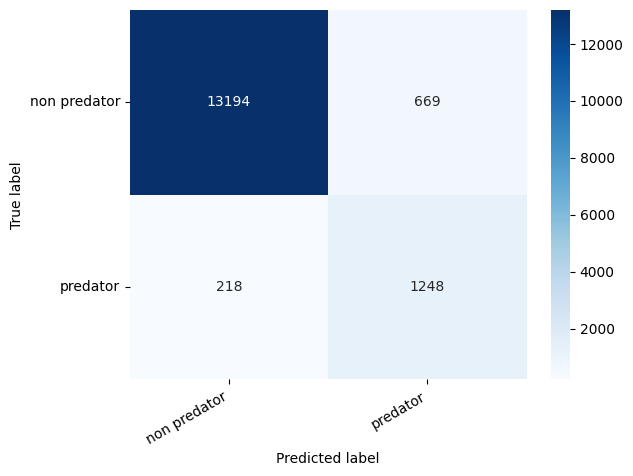

In [21]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test_nl, preds_nl)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
     

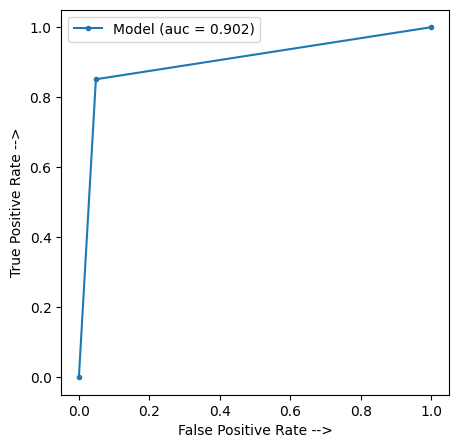

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_nl, preds_nl)
auc = auc(fpr, tpr)



plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [24]:
#missclassified examples 
misclassified = np.where(preds_nl != y_test_nl)
print(misclassified)

(array([    1,    30,    36,    40,    41,    75,    85,    86,    89,
         115,   133,   157,   162,   189,   204,   248,   255,   268,
         275,   284,   310,   328,   358,   369,   404,   409,   428,
         435,   438,   453,   464,   465,   498,   499,   537,   548,
         604,   607,   614,   623,   637,   675,   676,   678,   687,
         710,   712,   729,   756,   760,   780,   795,   858,   869,
         870,   876,   886,   901,   917,   929,   946,   961,   983,
         988,   990,  1012,  1031,  1042,  1051,  1052,  1081,  1084,
        1087,  1104,  1203,  1204,  1207,  1208,  1216,  1259,  1285,
        1287,  1314,  1343,  1344,  1352,  1354,  1362,  1374,  1402,
        1410,  1436,  1442,  1493,  1494,  1501,  1518,  1532,  1535,
        1571,  1576,  1591,  1602,  1632,  1662,  1664,  1687,  1701,
        1719,  1723,  1737,  1781,  1795,  1799,  1822,  1827,  1841,
        1853,  1868,  1910,  1936,  1939,  1943,  1958,  1969,  1987,
        1993,  2003

In [25]:
#example from the test data and its true and predicted labels
idx = 1827
review_text = nl_testset['messages_de'][idx]
true_sentiment = y_test_nl[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_nl[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_nl[idx]}')


['asl.', '13 f Zuid-Portland u?', 'Hallo.', 'Zoals oudere kerels?',
'Ja hoor.', '21m', 'koel.', 'pic?', 'op mijn pro.', 'Ik heb er 1.',
'Heel schattig.', "realy's", 'Ja.', 'Dat is het antwoord op de
vraag.', 'Je hebt een foto.', 'Ja', 'Maak contact met mij.', 'huh.',
"Kliek op de botton die foto's vertoont.", 'aan de bovenkant.', 'Het
zal niet werken.', 'Stuur het per e-mail.', 'Wat is je e-mail?', 'Het
is de eerste keer dat we het hebben gehad.', 'k h/o', 'kk', 'werd
verstuurd.', 'kk', 'Ik heb het vastgehouden.', 'omg ur schattig.',
'thanx.', 'waar je woont.', 'in Scarborough.', 'Is dat dicht bij me?',
'waar je woont.', 'Zuid-Portland', 'De volgende stad...', 'Ik ben hier
net in november verhuisd.', 'Vanwaar?', 'Michael.', 'o koel', 'Wat doe
je als 2 voor de lol?', 'We moeten uit de buurt komen.', 'U?',
'feestje lol.', 'haha.', "Als je nog meer foto's van je hebt...", 'Ja,
lol.', 'Kun je me wat sturen?', 'kk hang op.', 'Redigeer...', 'Er is
niets.', 'Laat me het e-mailen.', 'Wat heb j

In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification

#tokenizer_r = AutoTokenizer.from_pretrained("Constien/xmlRoberta_Dutch")
#model_r = AutoModelForSequenceClassification.from_pretrained("Constien/xmlRoberta_Dutch")